In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = "/home/clairegayral/Documents/openclassroom/data/P3/"
res_path = "/home/clairegayral/Documents/openclassroom/res/P3/"

## my .py : 
from P3_preprocess import *
import missing_values_treatment
import duplicates
import univariate_analysis
import multivariate_analysis

from sklearn import model_selection 
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.impute import KNNImputer


In [31]:
df_2015 = pd.read_csv(data_path+"2015-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)
df_2016 = pd.read_csv(data_path+"2016-building-energy-benchmarking.csv", 
                          low_memory=False)#, index_col=0)

print("In 2015 data :", df_2015.shape[0],
      " buildings and ", df_2015.shape[1],"variables")
print("Total NaNs = ", df_2015.isna().sum().sum(), 
      "(that is ",np.round(100*df_2015.isna().sum().sum()/(
        df_2015.shape[0]*df_2015.shape[1]),2), "%)")

In 2015 data : 3340  buildings and  47 variables
Total NaNs =  26512 (that is  16.89 %)


In [32]:
df_2015 = df_2015.rename(columns={"ZipCode":"Zip Codes"})
# df_2015["ZipCodes"] = df_2015["Zip Codes"].rename("ZipCode",copy=False)
# df_2015["ZipCode"]

# Data merge : 

I decided to merge the 2016 and 2015 dataframes, taking the mean value if the building is in both.

In [33]:
data = pd.merge(df_2016, df_2015, on ="OSEBuildingID" ,
               how = 'outer', suffixes=('', '_2015'))

def my_agg_by_mean(colname):
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res.mean(axis=1)
        data.drop(colname, axis=1, inplace=True)
    return(data)        
    
def my_agg_filling_missing(colname) :
    if colname[-5:] == "_2015":
        res = data.loc[:,[colname[:-5],colname]]
        data.at[:,colname[:-5]] = res[colname[:-5]].fillna(colname)
        data.drop(colname, axis=1, inplace=True)
    return(data)
    
float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

for colname in all_num_var:
    data = my_agg_by_mean(colname)
for colname in data.columns :
    data = my_agg_filling_missing(colname)
    
# data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]] = data[["BuildingType","PrimaryPropertyType","Neighborhood","ComplianceStatus"]].astype("category")
data[categorical_var] = data[categorical_var].astype("category")

float_var = data.loc[:,data.dtypes==float].columns.values
int_var = data.loc[:,data.dtypes==int].columns.values
all_num_var = np.concatenate((float_var,int_var))

# Variable type : 
First of all, it is essential to know what variable is relevant for my study. I used the graphical histogram or sorted plot of the variable serie, and I compared that to [the original page on Seattle data website](https://data.seattle.gov/dataset/2015-Building-Energy-Benchmarking/h7rm-fz6m) to determine what type each variable is. It allowed me to separate numerical, categorical and identification variable :  

array([1. , 2. , 2.5, 3. , 4. , 5. , 5.5, 6. , 7. ])

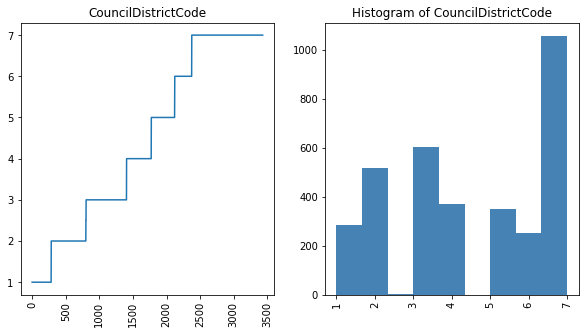

In [34]:
var = "CouncilDistrictCode"
univariate_analysis.repartition_and_hist(data,var)
np.unique(data[var])

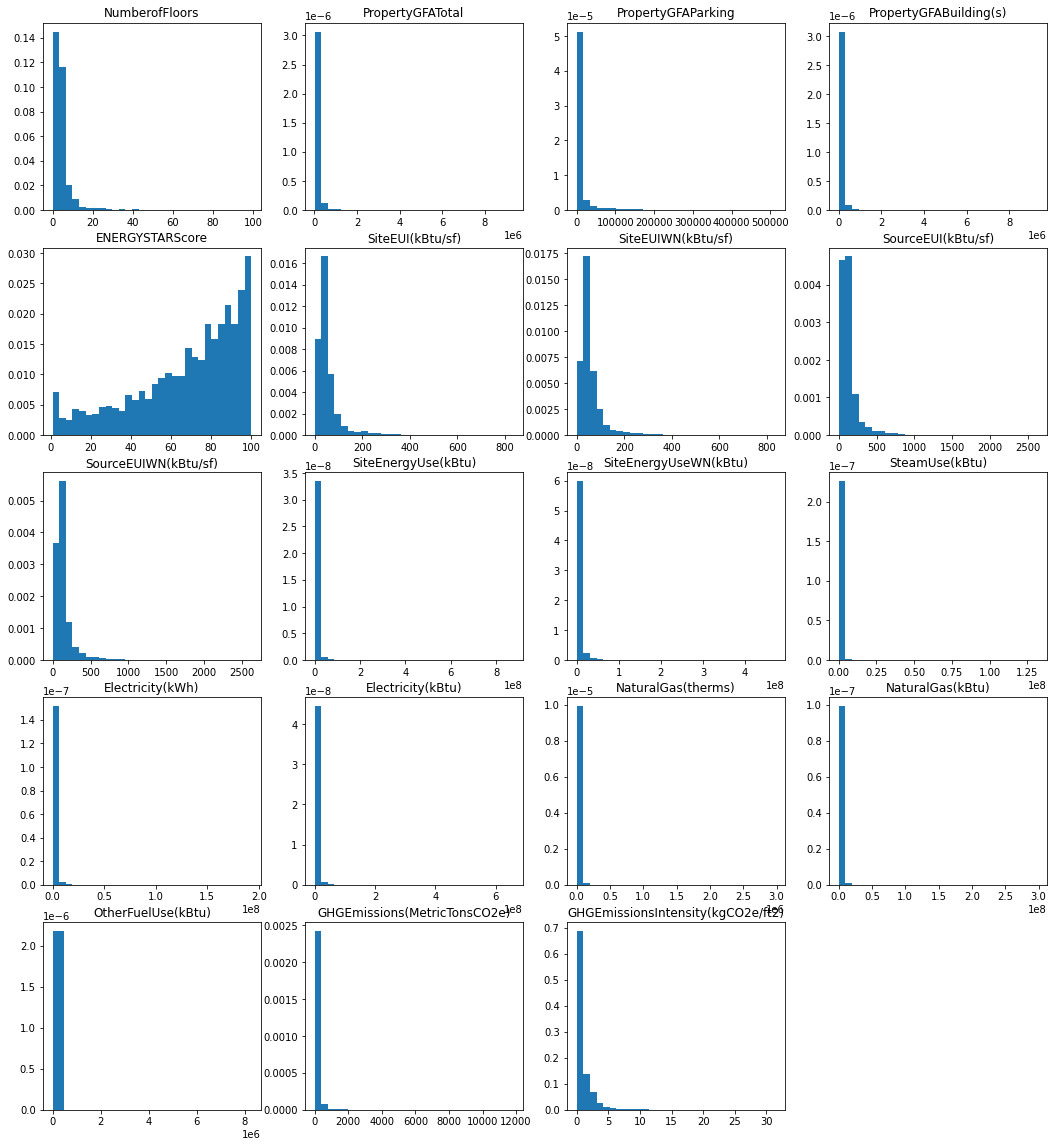

In [35]:
univariate_analysis.plot_multi_hist(data, numerical_var)

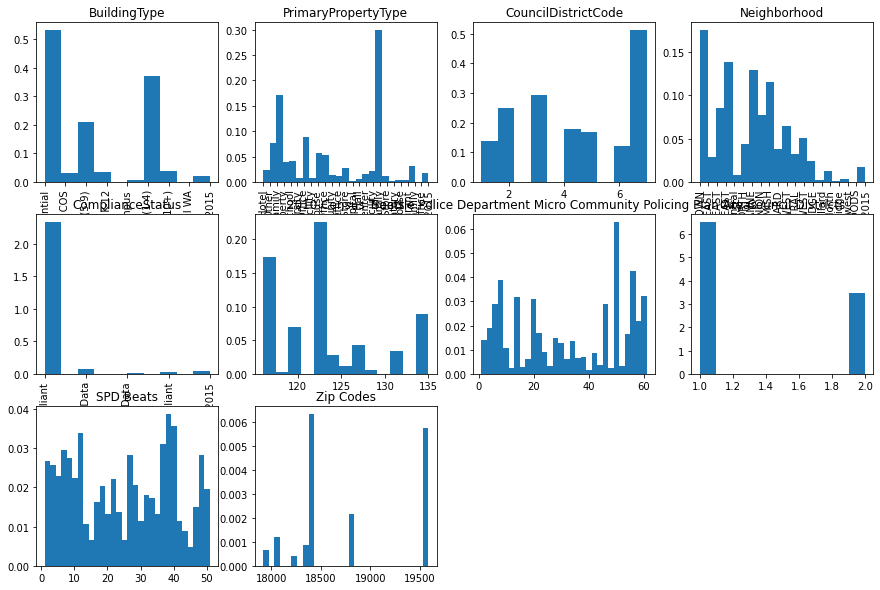

In [36]:
univariate_analysis.plot_multi_hist(data, categorical_var, figsize=(15,10))

## Prétraitement 
Les types semblent corrects (vérifiés avec df.dtypes). 

In [37]:
data.dtypes

OSEBuildingID                                                       int64
DataYear                                                          float64
BuildingType                                                     category
PrimaryPropertyType                                              category
PropertyName                                                       object
Address                                                            object
City                                                               object
State                                                              object
ZipCode                                                           float64
TaxParcelIdentificationNumber                                      object
CouncilDistrictCode                                              category
Neighborhood                                                     category
Latitude                                                          float64
Longitude                             

#####  Suppression colonnes vides :

In [72]:
# var_in_data = data.columns.intersection(all_num_var)
# # num_data = data.loc[:,num_var_in_data]#.set_index(data["OSEBuildingID"])

##
## drop empty columns
##

nan_repartition = data.isna().sum(axis=0)
# nan_threshold = nan_repartition.mean()
nan_threshold = nan_repartition.quantile(0.90)
new_data = data.drop(data.columns[nan_repartition>nan_threshold], axis = 1)

print("I drop variables with less than", 
      data.shape[0]-np.floor(nan_threshold),
      "values")
print("That is more than", np.floor(nan_threshold), "missing values")
print("I have dropped", data.shape[1] - new_data.shape[1], "variables :",
      data.columns[[var not in new_data.columns for var in data.columns]])

data = new_data

I drop variables with less than 2180.0 values
That is more than 1252.0 missing values
I have dropped 6 variables : Index(['SecondLargestPropertyUseTypeGFA', 'ThirdLargestPropertyUseTypeGFA',
       'Comments', 'Comment', '2010 Census Tracts', 'City Council Districts'],
      dtype='object')


In [74]:
## 
## drop columns with no variation :
##

data.var()

OSEBuildingID                        1.491289e+08
DataYear                             1.075651e-02
ZipCode                              3.465258e+02
Latitude                             2.280867e-03
Longitude                            7.400187e-04
YearBuilt                            1.101105e+03
NumberofBuildings                    3.968879e+00
NumberofFloors                       2.979493e+01
PropertyGFATotal                     4.717852e+10
PropertyGFAParking                   1.085955e+09
PropertyGFABuilding(s)               4.197745e+10
LargestPropertyUseTypeGFA            4.045401e+10
ENERGYSTARScore                      6.957487e+02
SiteEUI(kBtu/sf)                     3.124301e+03
SiteEUIWN(kBtu/sf)                   3.267006e+03
SourceEUI(kBtu/sf)                   1.897354e+04
SourceEUIWN(kBtu/sf)                 1.884458e+04
SiteEnergyUse(kBtu)                  4.634784e+14
SiteEnergyUseWN(kBtu)                2.546492e+14
SteamUse(kBtu)                       1.440721e+13


##### Gestion des doublons :

In [77]:
num_var_in_data = data.columns.intersection(all_num_var)

dict_duplicates = duplicates.get_index_merge_duplicates(data, num_var_in_data, 1.15)
print(dict_duplicates)

{}


##### Inférence valeurs manquantes : 

In [78]:
float_var = np.sort(all_num_var[[var not in ["ENERGYSTARScore", "OSEBuildingID"] for var in all_num_var]])
X = data[data.columns.intersection(float_var)].set_index(data["OSEBuildingID"])
y = data["ENERGYSTARScore"].reindex(data["OSEBuildingID"])
# X_std.columns.shape

In [79]:
for var in num_data.columns :
    print(var,": ", np.unique(df_2016[var]))

OSEBuildingID :  [    1     2     3 ... 50224 50225 50226]
DataYear :  [2016]
ZipCode :  [98006. 98011. 98012. 98013. 98020. 98028. 98033. 98040. 98053. 98070.
 98101. 98102. 98103. 98104. 98105. 98106. 98107. 98108. 98109. 98111.
 98112. 98113. 98114. 98115. 98116. 98117. 98118. 98119. 98121. 98122.
 98124. 98125. 98126. 98127. 98133. 98134. 98136. 98144. 98145. 98146.
 98154. 98155. 98164. 98165. 98168. 98177. 98178. 98181. 98185. 98191.
 98195. 98198. 98199. 98204. 98272.    nan    nan    nan    nan    nan
    nan    nan    nan    nan    nan    nan    nan    nan    nan    nan
    nan]
Latitude :  [47.49917    47.50061895 47.50224    ... 47.73368    47.73375
 47.73387   ]
Longitude :  [-122.41425   -122.41182   -122.41178   ... -122.26028   -122.25864
 -122.2209659]
YearBuilt :  [1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913
 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927
 1928 1929 1930 1931 1932 1935 1936 1937 1938 1939 1940 1941 1942 

KeyError: 'OtherFuelUse(kBtu)'

In [ ]:
##
## Standardize X : 
##

standardizer = preprocessing.StandardScaler().fit(X)
X_std = standardizer.transform(X)
X_std = pd.DataFrame(X_std, columns= X.columns, index = X.index)

# ##
# ## Set the best number of neighbors
# ##

my_meth = KNNImputer
param_grid = {"n_neighbors" : np.arange(1,25,1)}
cv = 3

res = missing_values_treatment.launch_my_pseudo_CV(X_std,my_meth,param_grid, cv = cv)
# Save dictionnary of results : 
import pickle
with open(res_path+"set_n_KNN_impute2"+".pkl", "wb") as f :
    pickle.dump(res, f, pickle.HIGHEST_PROTOCOL)

# import pickle
# with open(res_path+"set_n_KNN_impute"+".pkl", "rb") as f :
#         res = pickle.load(f)

# fig_name = "set_n_KNN_impute.jpg"
# missing_values_treatment.plot_MSE_scores_KNN_impute(res, param_grid, fig_name)

In [ ]:
## Impute missing values :
imputer = KNNImputer(n_neighbors=4)
pred_std = imputer.fit_transform(X_std)
pred_std = pd.DataFrame(pred_std, index = X.index, columns = X.columns)

## Inverse-standardize : 
# pred_std = pd.read_csv(res_path+"dataframe_std_KNN_impute.csv",index_col=0)
pred = standardizer.inverse_transform(pred_std)
pred = pd.DataFrame(pred, index = X.index, columns = X.columns)


##### Retrait des bâtiments sans le score : 

In [ ]:
index_to_drop = data[data["ENERGYSTARScore"].isna().values].index
data = data.drop(index_to_drop,axis=0)

X = data[float_var]
X_pred = pred.drop(index_to_drop,axis=0)
y = data["ENERGYSTARScore"]

## Etude des variables descriptives numériques

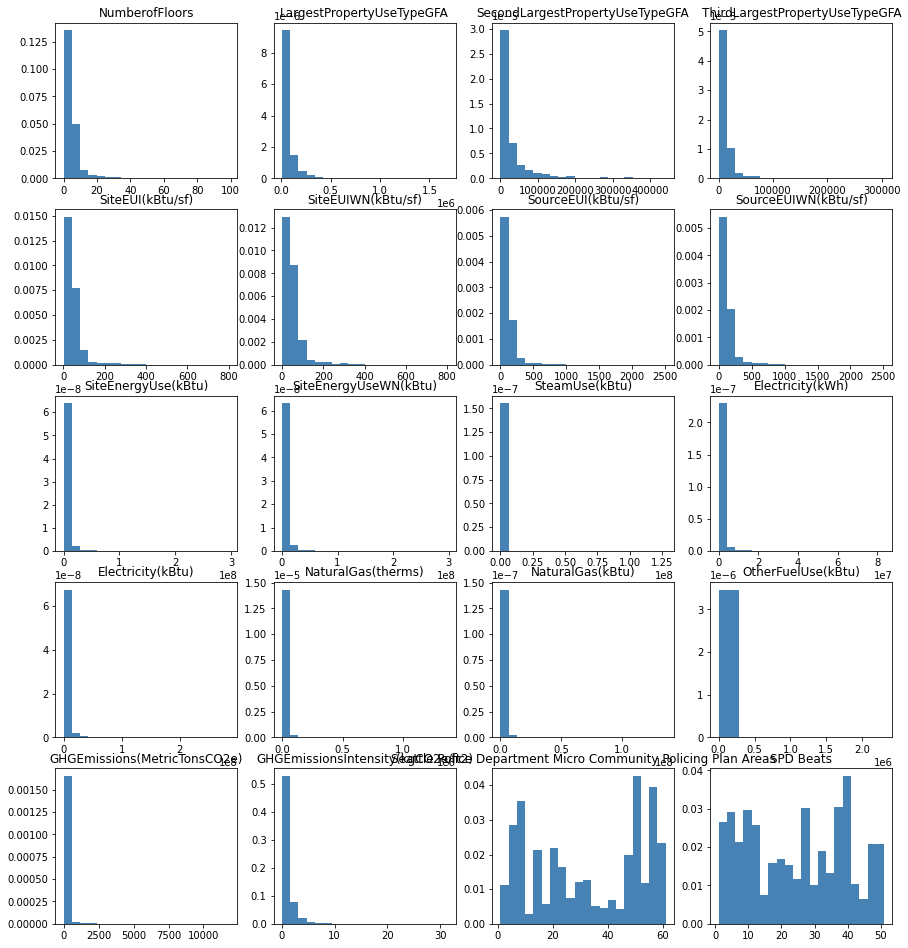

In [58]:
nb_line_plot = int(np.floor(len(float_var)/4)+1)
fig = plt.figure(figsize=(15, 20))

fig_count = 1
for var in float_var :#data.columns.intersection(list_of_nutri_facts):
    ax = fig.add_subplot(nb_line_plot,4, fig_count)
    nb_bins = min(20, len(np.unique(data[var].dropna().values)))
    ax.hist(data[var], bins = nb_bins, color='steelblue', density=True, edgecolor='none')
    ax.set_title(var)
    fig_count += 1
plt.show()

In [10]:
data["Seattle Police Department Micro Community Policing Plan Areas"]
data["SPD Beats"]

OSEBuildingID
1        31.0
2        31.0
3        31.0
5        31.0
8        31.0
         ... 
50049    16.0
50055    38.0
50057     7.0
50058    48.0
50059    48.0
Name: SPD Beats, Length: 2560, dtype: float64

## Etude de la variable de réponse 

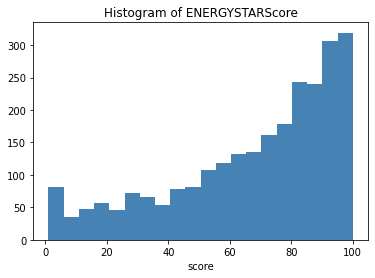

count    2560.000000
mean       67.894141
std        27.154057
min         1.000000
25%        51.750000
50%        76.000000
75%        90.000000
max       100.000000
Name: ENERGYSTARScore, dtype: float64

In [11]:
import univariate_analysis

univariate_analysis.plot_hist_y(y)
    
y.describe()

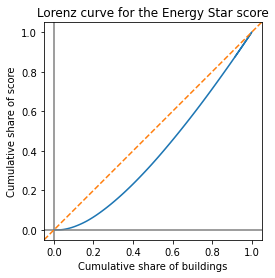

gini = 0.22380585297213407
AUC = 0.38809707351393297


In [11]:
univariate_analysis.plot_lorenz_curve(y)